
# BDV & trends - EBL vs pallium neuron counts



✅ Merged 131 species with both neuron and EBL data.

🔹 Spearman correlations (log10 scale):
  Orthobornavirus rho=0.383, p=0.0177
  Carbovirus      rho=0.755, p=4.23e-08
  Cultervirus     rho=0.127, p=0.446
  Total_EBLs      rho=0.477, p=0.00246


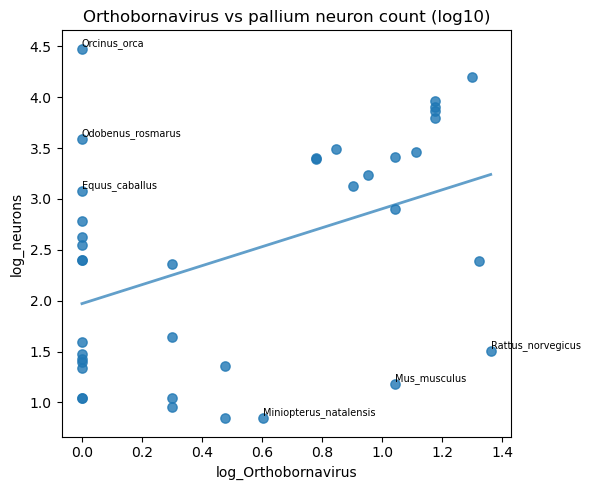

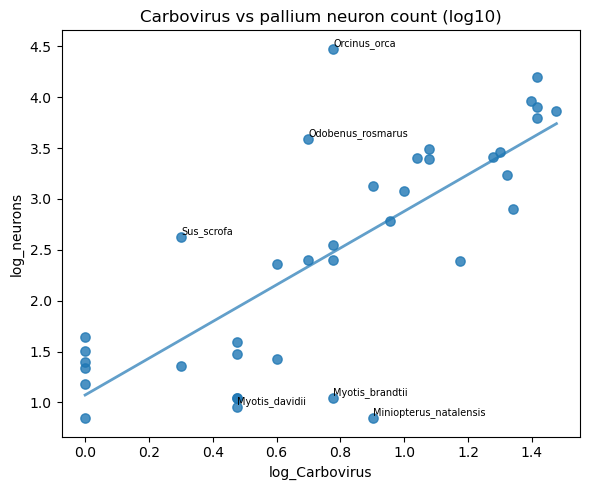

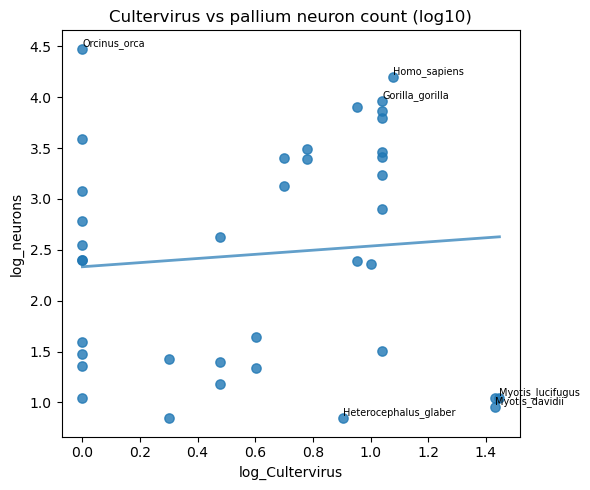

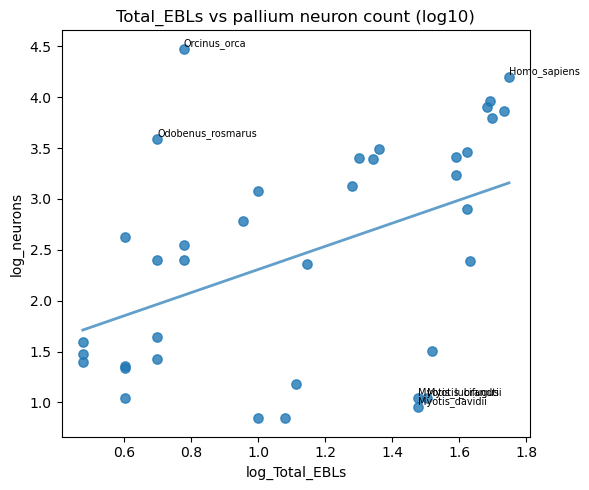

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import numpy as np

# --- Load data ---
ebl = pd.read_csv("EBL_counts_per_species_modified.csv")
neur = pd.read_csv("hosts_neurons.csv")

# --- Clean and standardize species names ---
ebl["host_species_clean"] = ebl["Host_species"].astype(str).str.strip().str.lower()
neur["host_species_clean"] = neur["host_species"].astype(str).str.strip().str.lower()

# --- Merge datasets ---
merged = ebl.merge(neur, on="host_species_clean", how="inner")
print(f"✅ Merged {len(merged)} species with both neuron and EBL data.\n")

# --- Define columns ---
ebl_cols = ["Orthobornavirus", "Carbovirus", "Cultervirus", "Total_EBLs"]
neuron_col = "neuron_count"  # adapt if needed
species_col = "Host_species"

# ensure numeric
merged[neuron_col] = pd.to_numeric(merged[neuron_col], errors="coerce")
for c in ebl_cols:
    merged[c] = pd.to_numeric(merged[c], errors="coerce")

# --- Log-transform (avoid log(0)) ---
merged["log_neurons"] = np.log10(merged[neuron_col] + 1)
for c in ebl_cols:
    merged[f"log_{c}"] = np.log10(merged[c] + 1)

print("🔹 Spearman correlations (log10 scale):")
for c in ebl_cols:
    x = merged[f"log_{c}"]
    y = merged["log_neurons"]
    mask = x.notna() & y.notna()
    if mask.sum() >= 3 and x[mask].nunique() > 1 and y[mask].nunique() > 1:
        rho, p = spearmanr(x[mask], y[mask])
        print(f"  {c:<15s} rho={rho:.3f}, p={p:.3g}")
    else:
        print(f"  {c:<15s} insufficient variation / points for correlation")

def plot_with_labels(xcol, ycol, labelcol, df, title, highlight=None):
    # keep only finite values
    sub = df[[xcol, ycol, labelcol]].replace([np.inf, -np.inf], np.nan).dropna()
    if len(sub) < 3 or sub[xcol].nunique() <= 1 or sub[ycol].nunique() <= 1:
        print(f"⚠️ Skipping trend line for {title}: not enough variation/points.")
        plt.figure(figsize=(6,5))
        plt.scatter(sub[xcol], sub[ycol], s=45, alpha=0.8)
        for _, row in sub.iterrows():
            plt.text(row[xcol], row[ycol], row[labelcol], fontsize=7,
                     ha='left', va='bottom')
        plt.title(title + " (no fit)")
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        plt.tight_layout()
        plt.show()
        return

    # fit line safely on clean subset
    coeffs = np.polyfit(sub[xcol], sub[ycol], 1)
    fit_fn = np.poly1d(coeffs)
    residuals = sub[ycol] - fit_fn(sub[xcol])

    # select labels: top/bottom residuals + optional highlights
    top_outliers = sub.loc[residuals.nlargest(3).index]
    bottom_outliers = sub.loc[residuals.nsmallest(3).index]
    label_df = pd.concat([top_outliers, bottom_outliers])

    if highlight:
        label_df = pd.concat([
            label_df,
            sub[sub[labelcol].isin(highlight)]
        ]).drop_duplicates()

    # plot
    plt.figure(figsize=(6,5))
    plt.scatter(sub[xcol], sub[ycol], s=45, alpha=0.8)
    # regression line
    xs = np.linspace(sub[xcol].min(), sub[xcol].max(), 100)
    plt.plot(xs, fit_fn(xs), linewidth=2, alpha=0.7)

    # labels
    for _, row in label_df.iterrows():
        plt.text(row[xcol], row[ycol], row[labelcol],
                 fontsize=7, ha='left', va='bottom')

    plt.title(title)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.tight_layout()
    plt.show()

species_to_highlight = [
    "Homo sapiens", "Rattus norvegicus", "Pan Paniscus", "Canis lupus", "Rousettus aegyptiacus", "Hipposideros armiger", "Gorilla gorilla", "Hetereocephalus glaber", "Miniopterus natalensis"
]

for c in ebl_cols:
    plot_with_labels(
        xcol=f"log_{c}",
        ycol="log_neurons",
        labelcol=species_col,
        df=merged,
        title=f"{c} vs pallium neuron count (log10)",
        highlight=species_to_highlight
    )

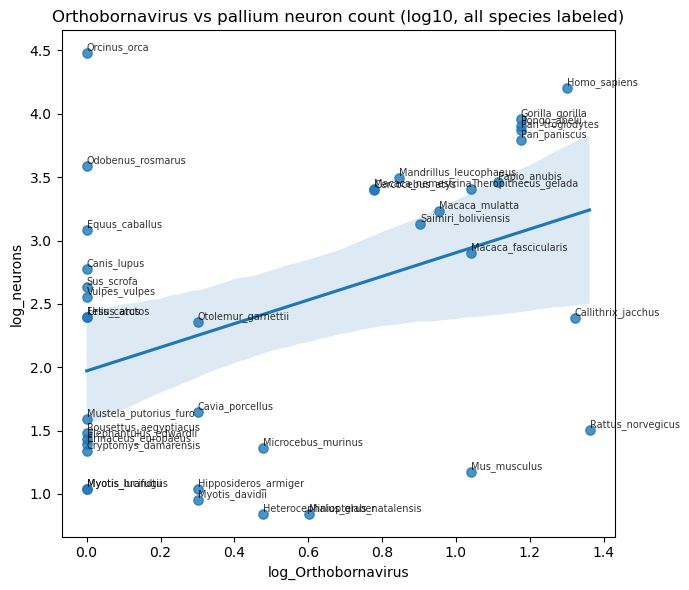

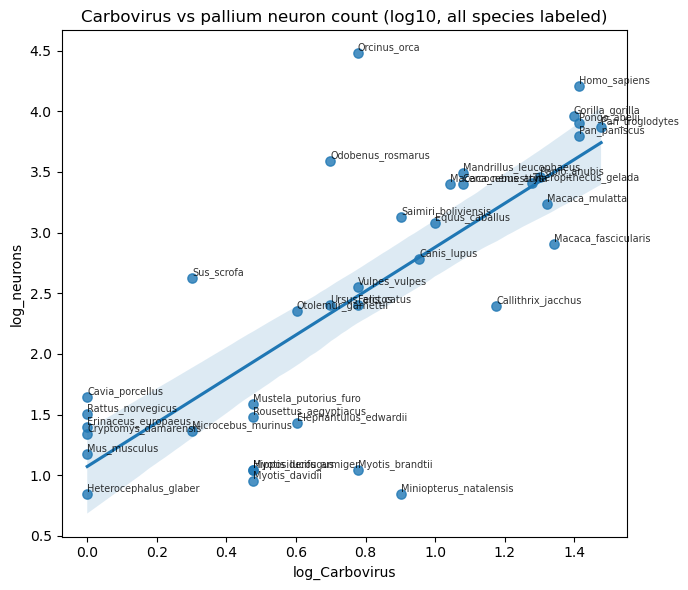

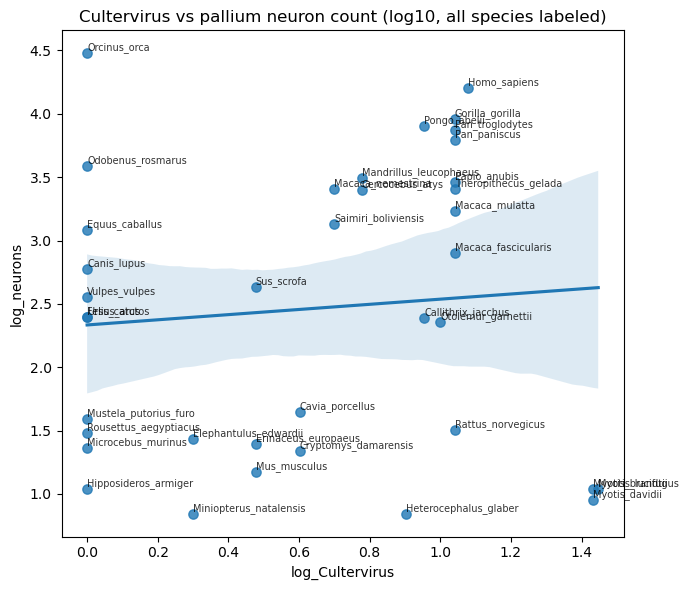

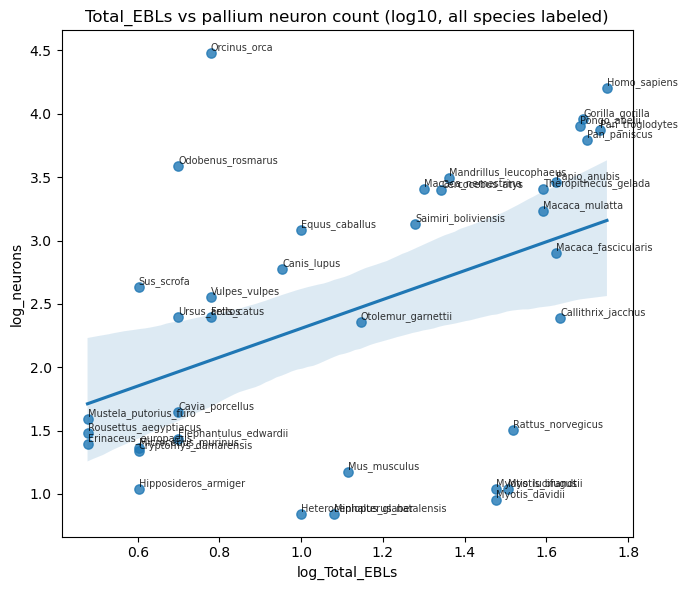

In [5]:
# --- LABELS ALL SPECIES AND SEE SLOPE



def plot_with_all_labels(xcol, ycol, labelcol, df, title):
    sub = df[[xcol, ycol, labelcol]].replace([np.inf, -np.inf], np.nan).dropna()
    plt.figure(figsize=(7,6))
    sns.regplot(x=xcol, y=ycol, data=sub, scatter_kws={"s": 45, "alpha": 0.8})
    
    # Add species labels
    for _, row in sub.iterrows():
        plt.text(row[xcol], row[ycol], row[labelcol],
                 fontsize=7, ha='left', va='bottom', alpha=0.8)
    
    plt.title(title)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.tight_layout()
    plt.show()

# --- Generate plots ---
for c in ebl_cols:
    plot_with_all_labels(
        xcol=f"log_{c}",
        ycol="log_neurons",
        labelcol=species_col,
        df=merged,
        title=f"{c} vs pallium neuron count (log10, all species labeled)"
    )